In [2]:
import os
import csv
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [148]:
# DATA PARAMETERS

survey = "HERMES" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 6260 # minimum wavelength of the data
max_wv = 6300 # maximum wavelength of the data
spec_dir = r"C:\Users\kentb\Desktop\PDM\data\Hermes\RRLyr_Hermes_spectra" # directory of the spectrum
rv_dir = r"C:\Users\kentb\Desktop\PDM\data\RV\RRLyr_rv.csv" # directory of the RVs
results_dir = r"C:\Users\kentb\Desktop\PDM\thesis\main\Hermes"

In [149]:
obs_data = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,
                        target_visits_lib=spec_dir)
df = pd.read_csv(rv_dir)
rv = df.rv.astype(float).values
e_rv = df.rv_err.astype(float).values
times = df.bjd.astype(float).values
if survey == "CORALIE": 
    ids = df.unique_id.astype(str).values
elif survey == "HERMES":
    ids = df.unique_id.astype(int).values

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\data\Hermes\RRLyr_Hermes_spectra
Selected directory: C:\Users\kentb\Desktop\PDM\data\Hermes\RRLyr_Hermes_spectra


In [133]:
# Preprocess the spectra

for i in obs_data.time_series.vals:
    i = i.InterpolateSpectrum()
    i = i.FilterSpectrum(lowcut=3, highcut=0.15, order = 1)
    i = i.ApplyCosineBell(alpha=0.3)

In [150]:
for i in obs_data.time_series.vals:
    i = i.InterpolateSpectrum()

In [151]:
# Rearrange the RVs with the spectra
#obs_data.time_series.times = [i-int(min(times)) for i in obs_data.time_series.times]
obs_data.rearrange_time_series(rv=rv, times=times,ids=ids,unique_id=True)

Matching ratio -> 100 %


In [152]:
# PERIODOGRAM PARAMETERS

baseline = int(abs(obs_data.time_series.times[-1]-obs_data.time_series.times[0]))
min_freq = 1/10#1/2/baseline # Or maybe 1/2/baseline to be sure but let's test it that way.
max_freq = 2 # we don't expect more than one pulsation every two day so should be alright.
freq_range = (min_freq, max_freq) # frequency range of the periodograms
points_per_peak = 5
periodogram_grid_resolution = points_per_peak*max_freq*baseline # frequency resolution of the periodograms

In [153]:
# Choosing frequency range and frequency resolution for the periodograms.
obs_data.initialize_periodicity_detector(freq_range=freq_range,
                                        periodogram_grid_resolution=periodogram_grid_resolution)

In [154]:
obs_data.periodicity_detector.calc_GLS()

print("GLS done", flush=True)

obs_data.periodicity_detector.calc_USURPER()

print("USURPER done",flush=True)

obs_data.periodicity_detector.calc_PDC()

print("PDC done",flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shape")

print("Shape done",flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shift")

print("Shift done",flush=True)

GLS done


USURPER done
PDC done
Shape done
Shift done


In [155]:
with open(os.path.join(results_dir, f"{spec_dir.rsplit('/',maxsplit=1)[-1]}_{str(min_wv)}_{str(max_wv)}.csv"), 'w',newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["freq", "gls","usurper","pdc_unbiased","shape_periodogram", "shift_periodogram"])
    for i in range(len(obs_data.periodicity_detector.results_frequency['GLS'])):
        writer.writerow([obs_data.periodicity_detector.results_frequency['GLS'][i],
                         obs_data.periodicity_detector.results_power['GLS'][i],
                         obs_data.periodicity_detector.results_power['USURPER'][i],
                         obs_data.periodicity_detector.results_power['PDC_unbiased'][i],
                         obs_data.periodicity_detector.results_power['shape_periodogram'][i],
                         obs_data.periodicity_detector.results_power['shift_periodogram'][i]])

In [3]:
#open the csv file and plot the periodograms
df = pd.read_csv('delCep_Hermes_spectra_4000_4200.csv')
freq = 1/df.freq.astype(float).values
gls = df.gls.astype(float).values
usurper = df.usurper.astype(float).values
pdc = df.pdc_unbiased.astype(float).values
shape = df.shape_periodogram.astype(float).values
shift = df.shift_periodogram.astype(float).values

In [6]:
plt.style.use('sparta')
from sparta import Statistics as stat

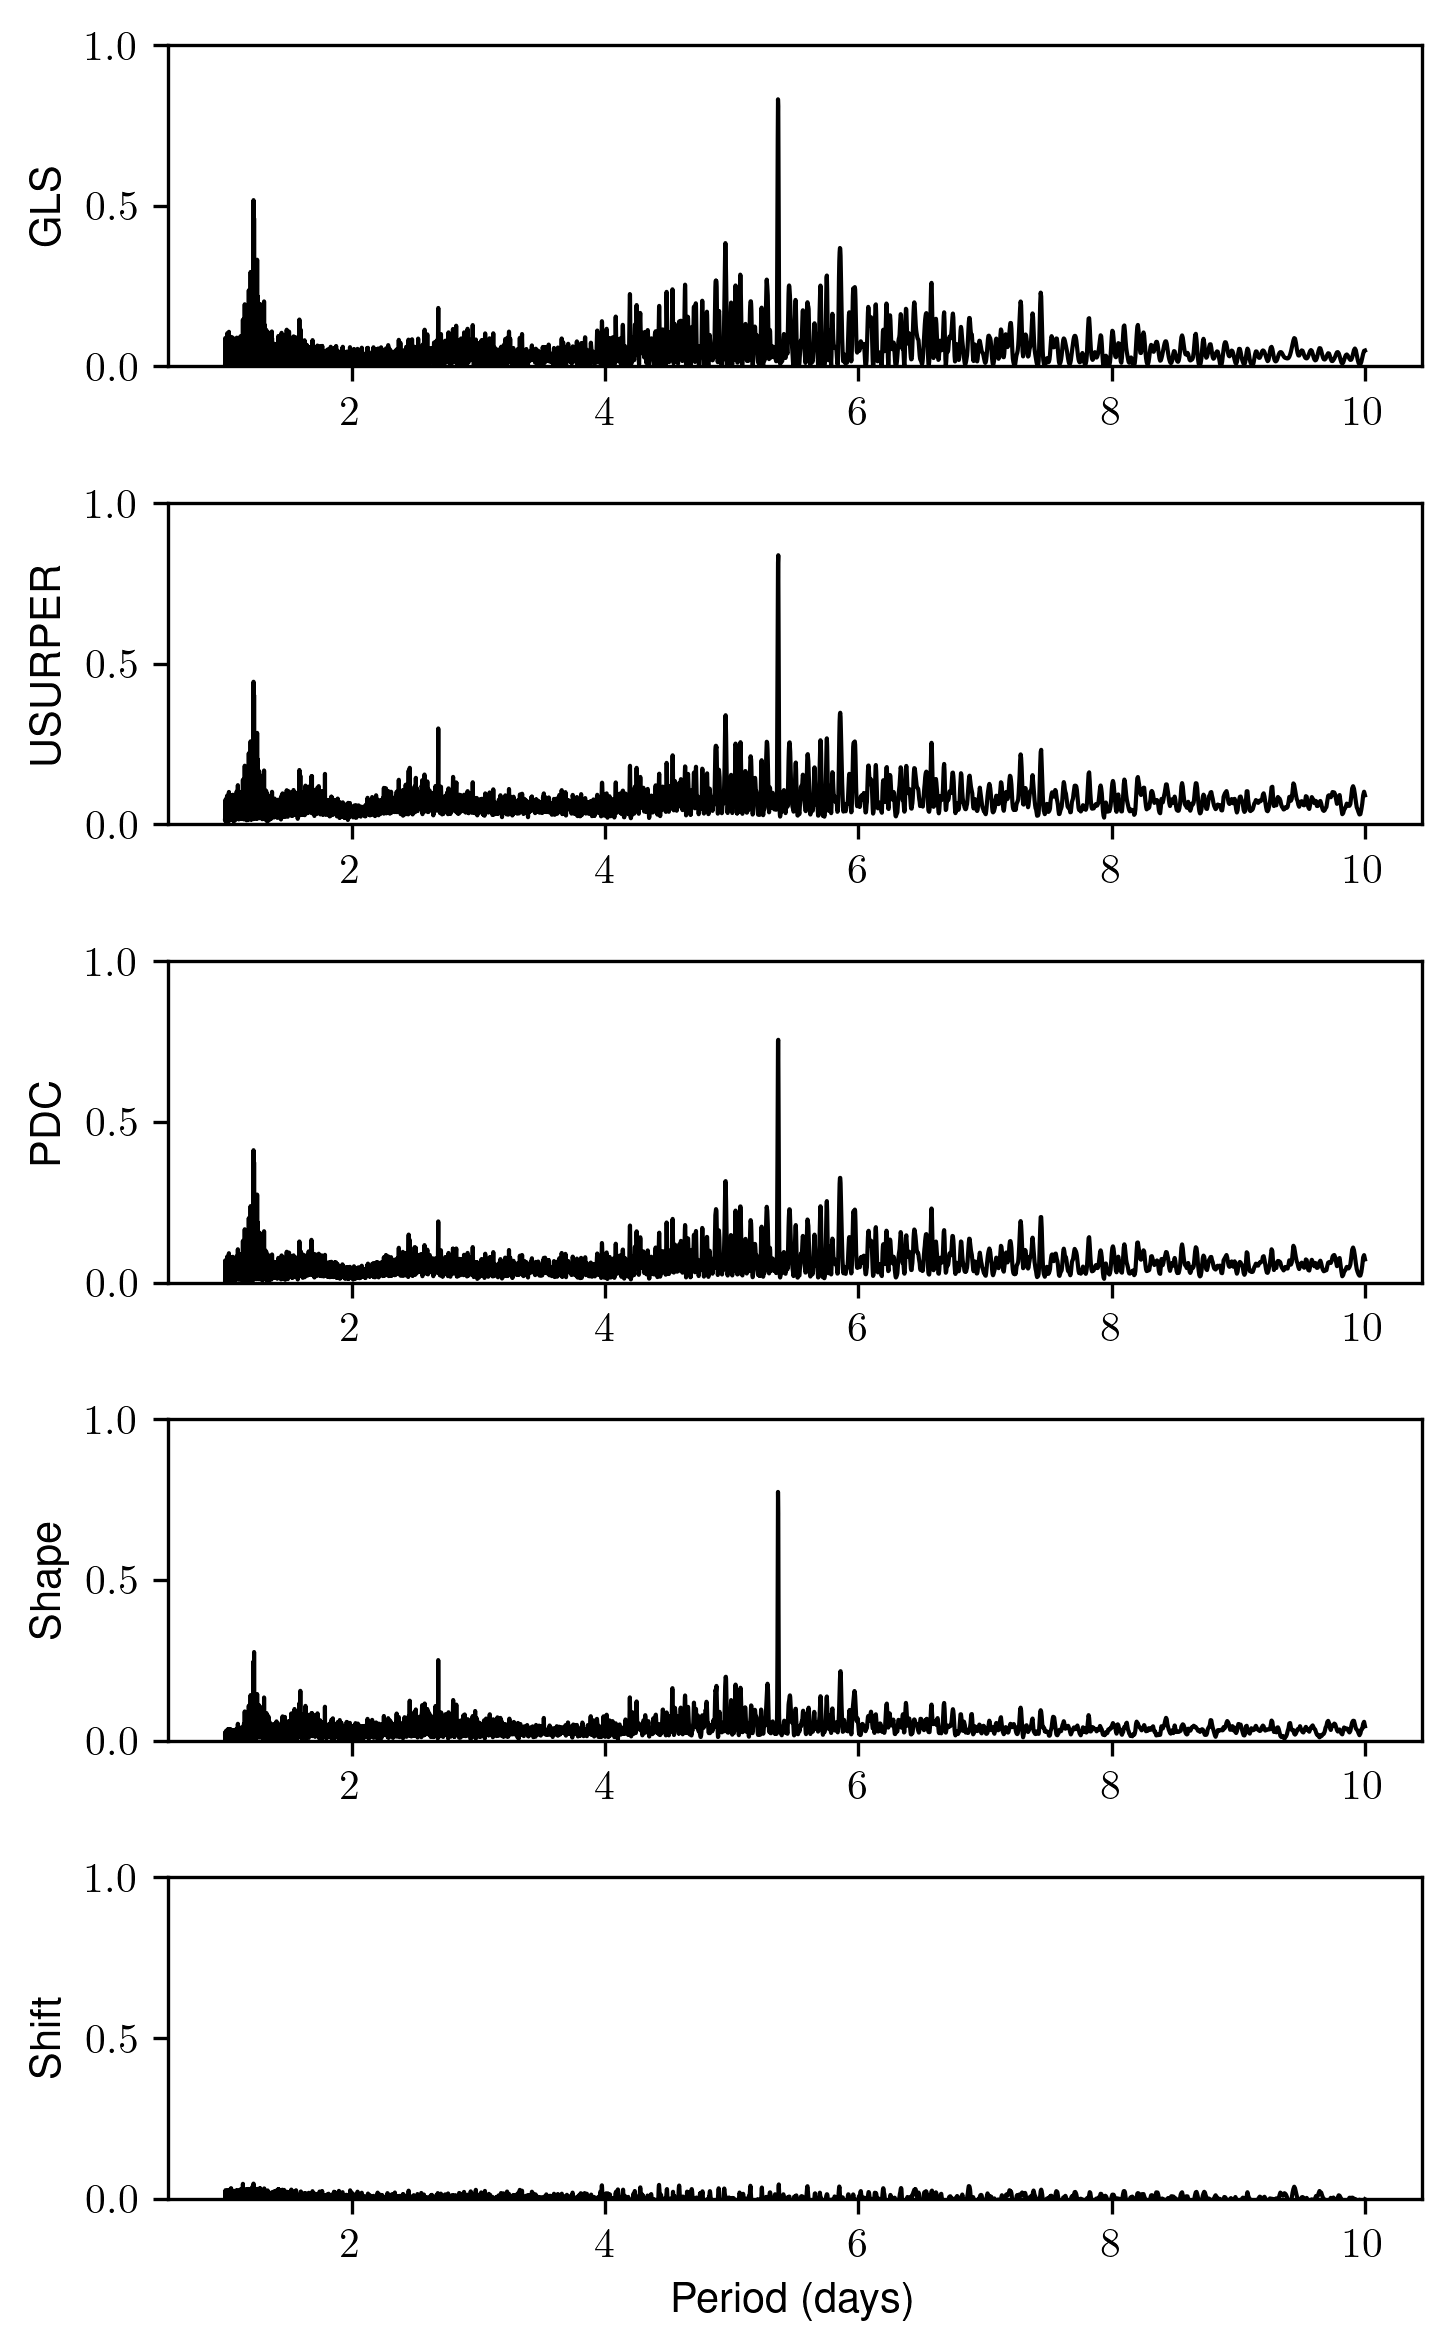

In [5]:
_, ax = plt.subplots(df.shape[1]-1,squeeze=False)
ax[0,0].plot(freq,gls)
ax[0,0].set_ylabel('GLS')
ax[1,0].plot(freq,usurper)
ax[1,0].set_ylabel('USURPER')
ax[2,0].plot(freq,pdc)
ax[2,0].set_ylabel('PDC')
ax[3,0].plot(freq,shape)
ax[3,0].set_ylabel('Shape')
ax[4,0].plot(freq,shift)
ax[4,0].set_ylabel('Shift')
ax[4,0].set_xlabel('Period (days)')
for i in ax:
    i[0].set_ylim(0,1)
plt.tight_layout()
plt.show()



In [13]:
obs_data.periodicity_detector.period_truth = [5.366267]

Shape has highest peak
Relative error on period:  0.00012157699652477481
Max shape peak power:  0.7729066874568038
Max shift peak power:  0.04652759874096344
Ratio of max shape to max shift:  16.611789741393377


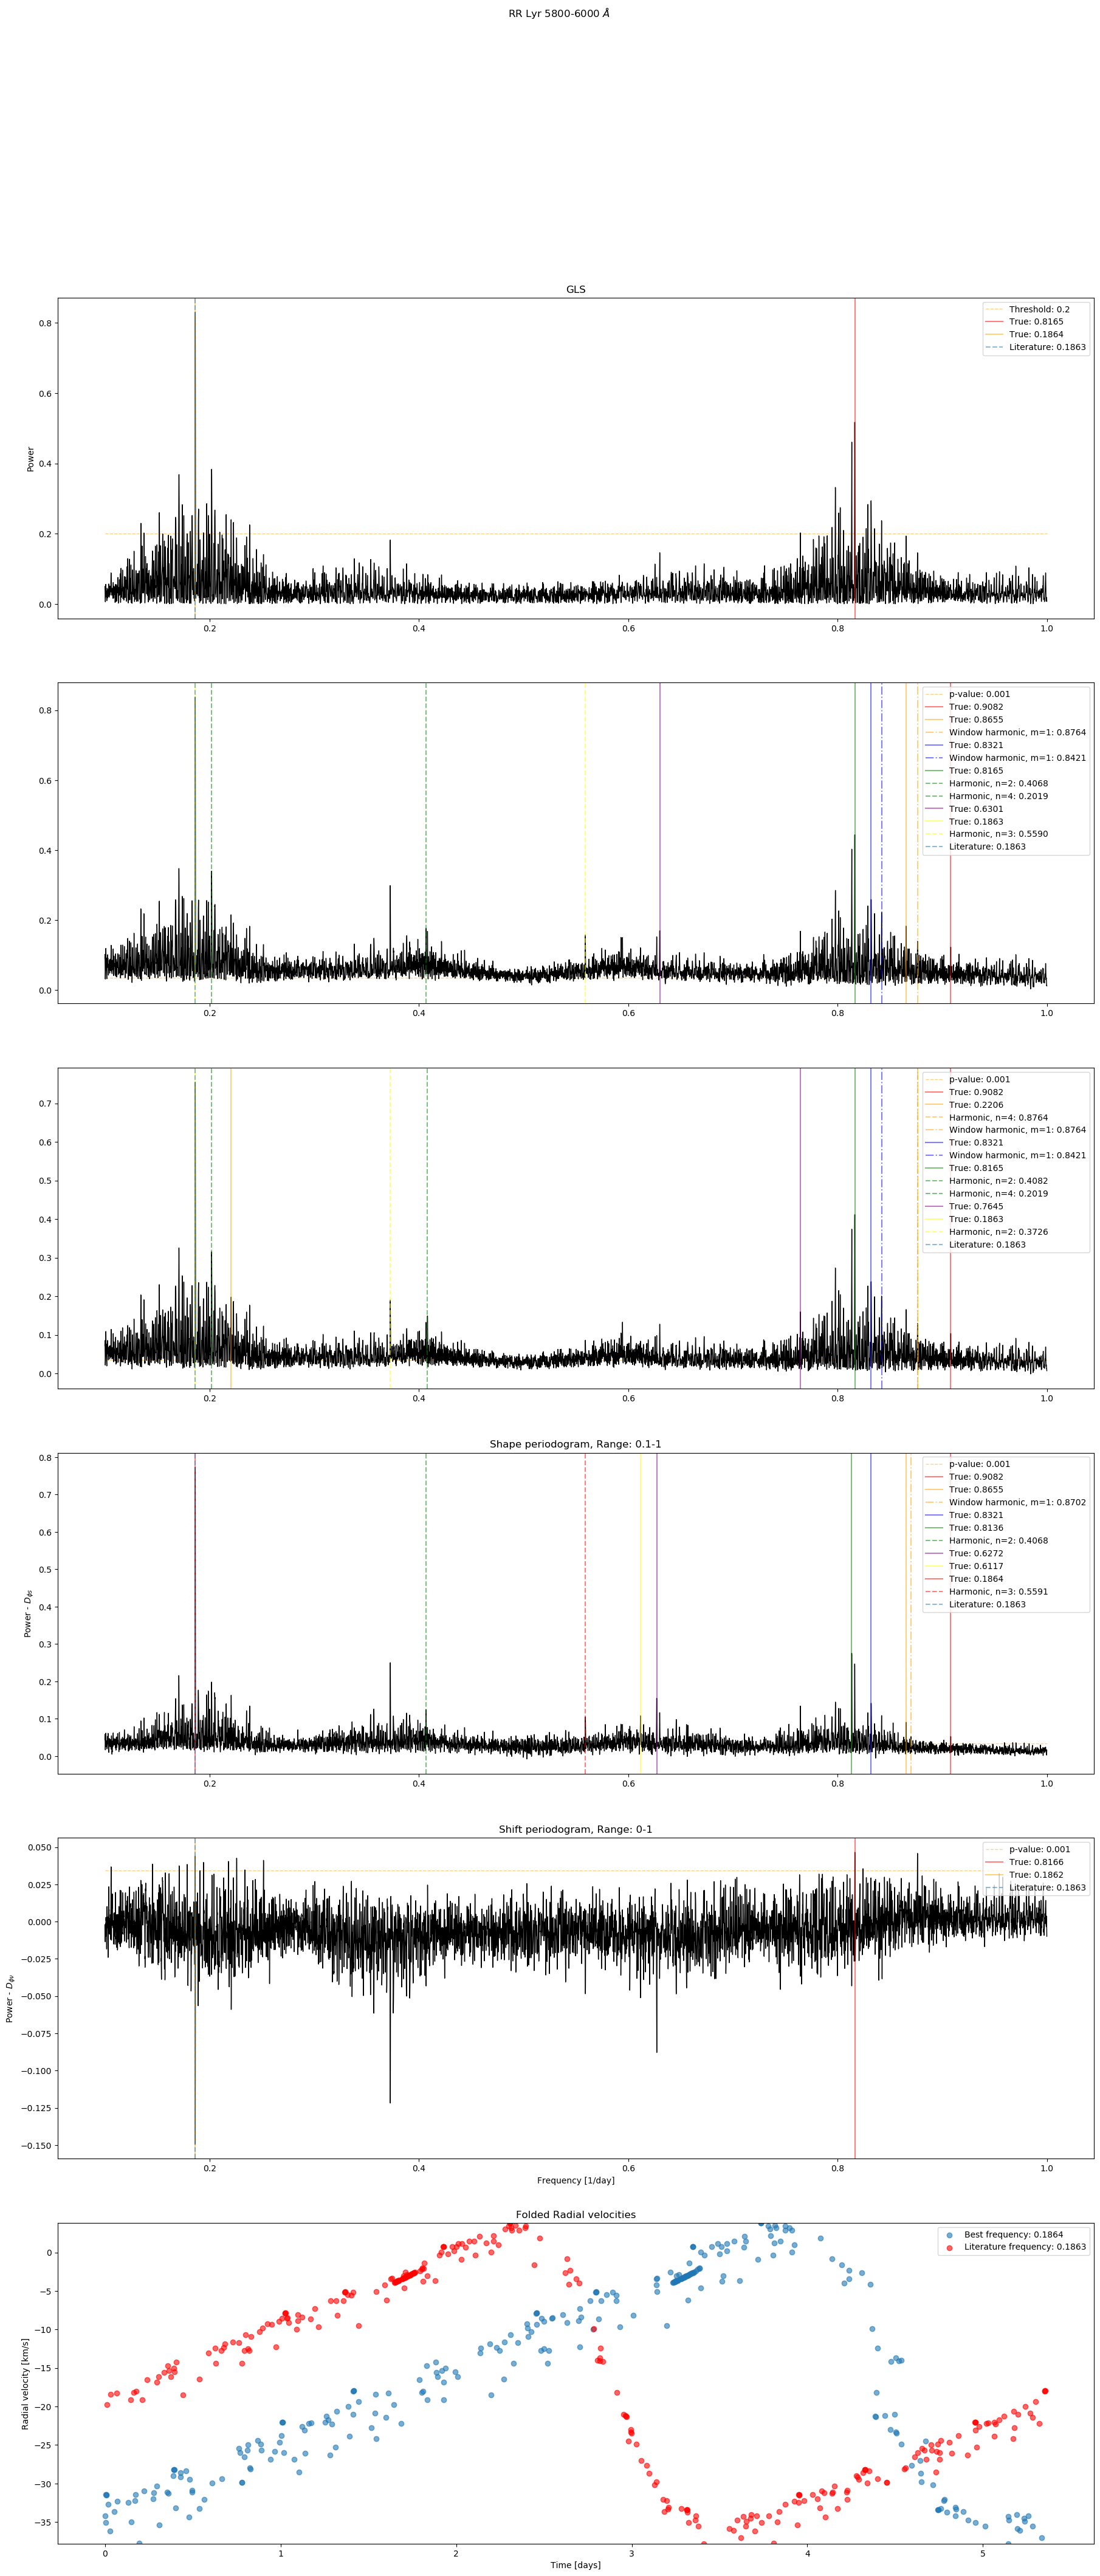

In [14]:
# Plotting the periodograms

obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-3], plot_rv=True,title=r"RR Lyr 5800-6000 $\AA$", log_scale=False, plot_peaks=True)

In [2]:
# Load the data

path = os.path.join(r'C:\Users\kentb\Desktop\PDM\data\products\Hermes', 'RRLyr_Hermes_5600_5800.pkl')
file = open(path, "rb")
obs_data = pickle.load(file)
file.close()

In [3]:
obs_data.periodicity_detector.period_truth = [0.566777]
# obs_data.periodicity_detector.period_truth = None

Before cleaning peaks:  [1.76436338 0.76150215 0.25735336]
After removing close peaks:  [1.76436338 0.76150215 0.25735336]
Current peak:  1.7643633762517799
Current peak to compare:  0.7615021459227431
Current harmonic:  2
Current harmonic:  3
Current harmonic:  4
Current harmonic:  5
Current harmonic:  6
Current harmonic:  7
Window harmonic 1 of 1.7643633762517799 found at 0.7615021459227431
[]
Current peak to compare:  0.2573533619456354
Current harmonic:  2
Current harmonic:  3
Current harmonic:  4
Current harmonic:  5
Current harmonic:  6
Current harmonic:  7
this peak is not a harmonic of another peak:  1.7643633762517799
Peaks:  [1.7643633762517799, [], ['1', 0.7615021459227431]]
Current peak:  0.7615021459227431
Current peak to compare:  0.2573533619456354
Current harmonic:  2
Current harmonic:  3
Harmonic 3 of 0.7615021459227431 found at 0.2573533619456354
['3', 0.2573533619456354]
Current harmonic:  4
Current harmonic:  5
Current harmonic:  6
Current harmonic:  7
Current peak:

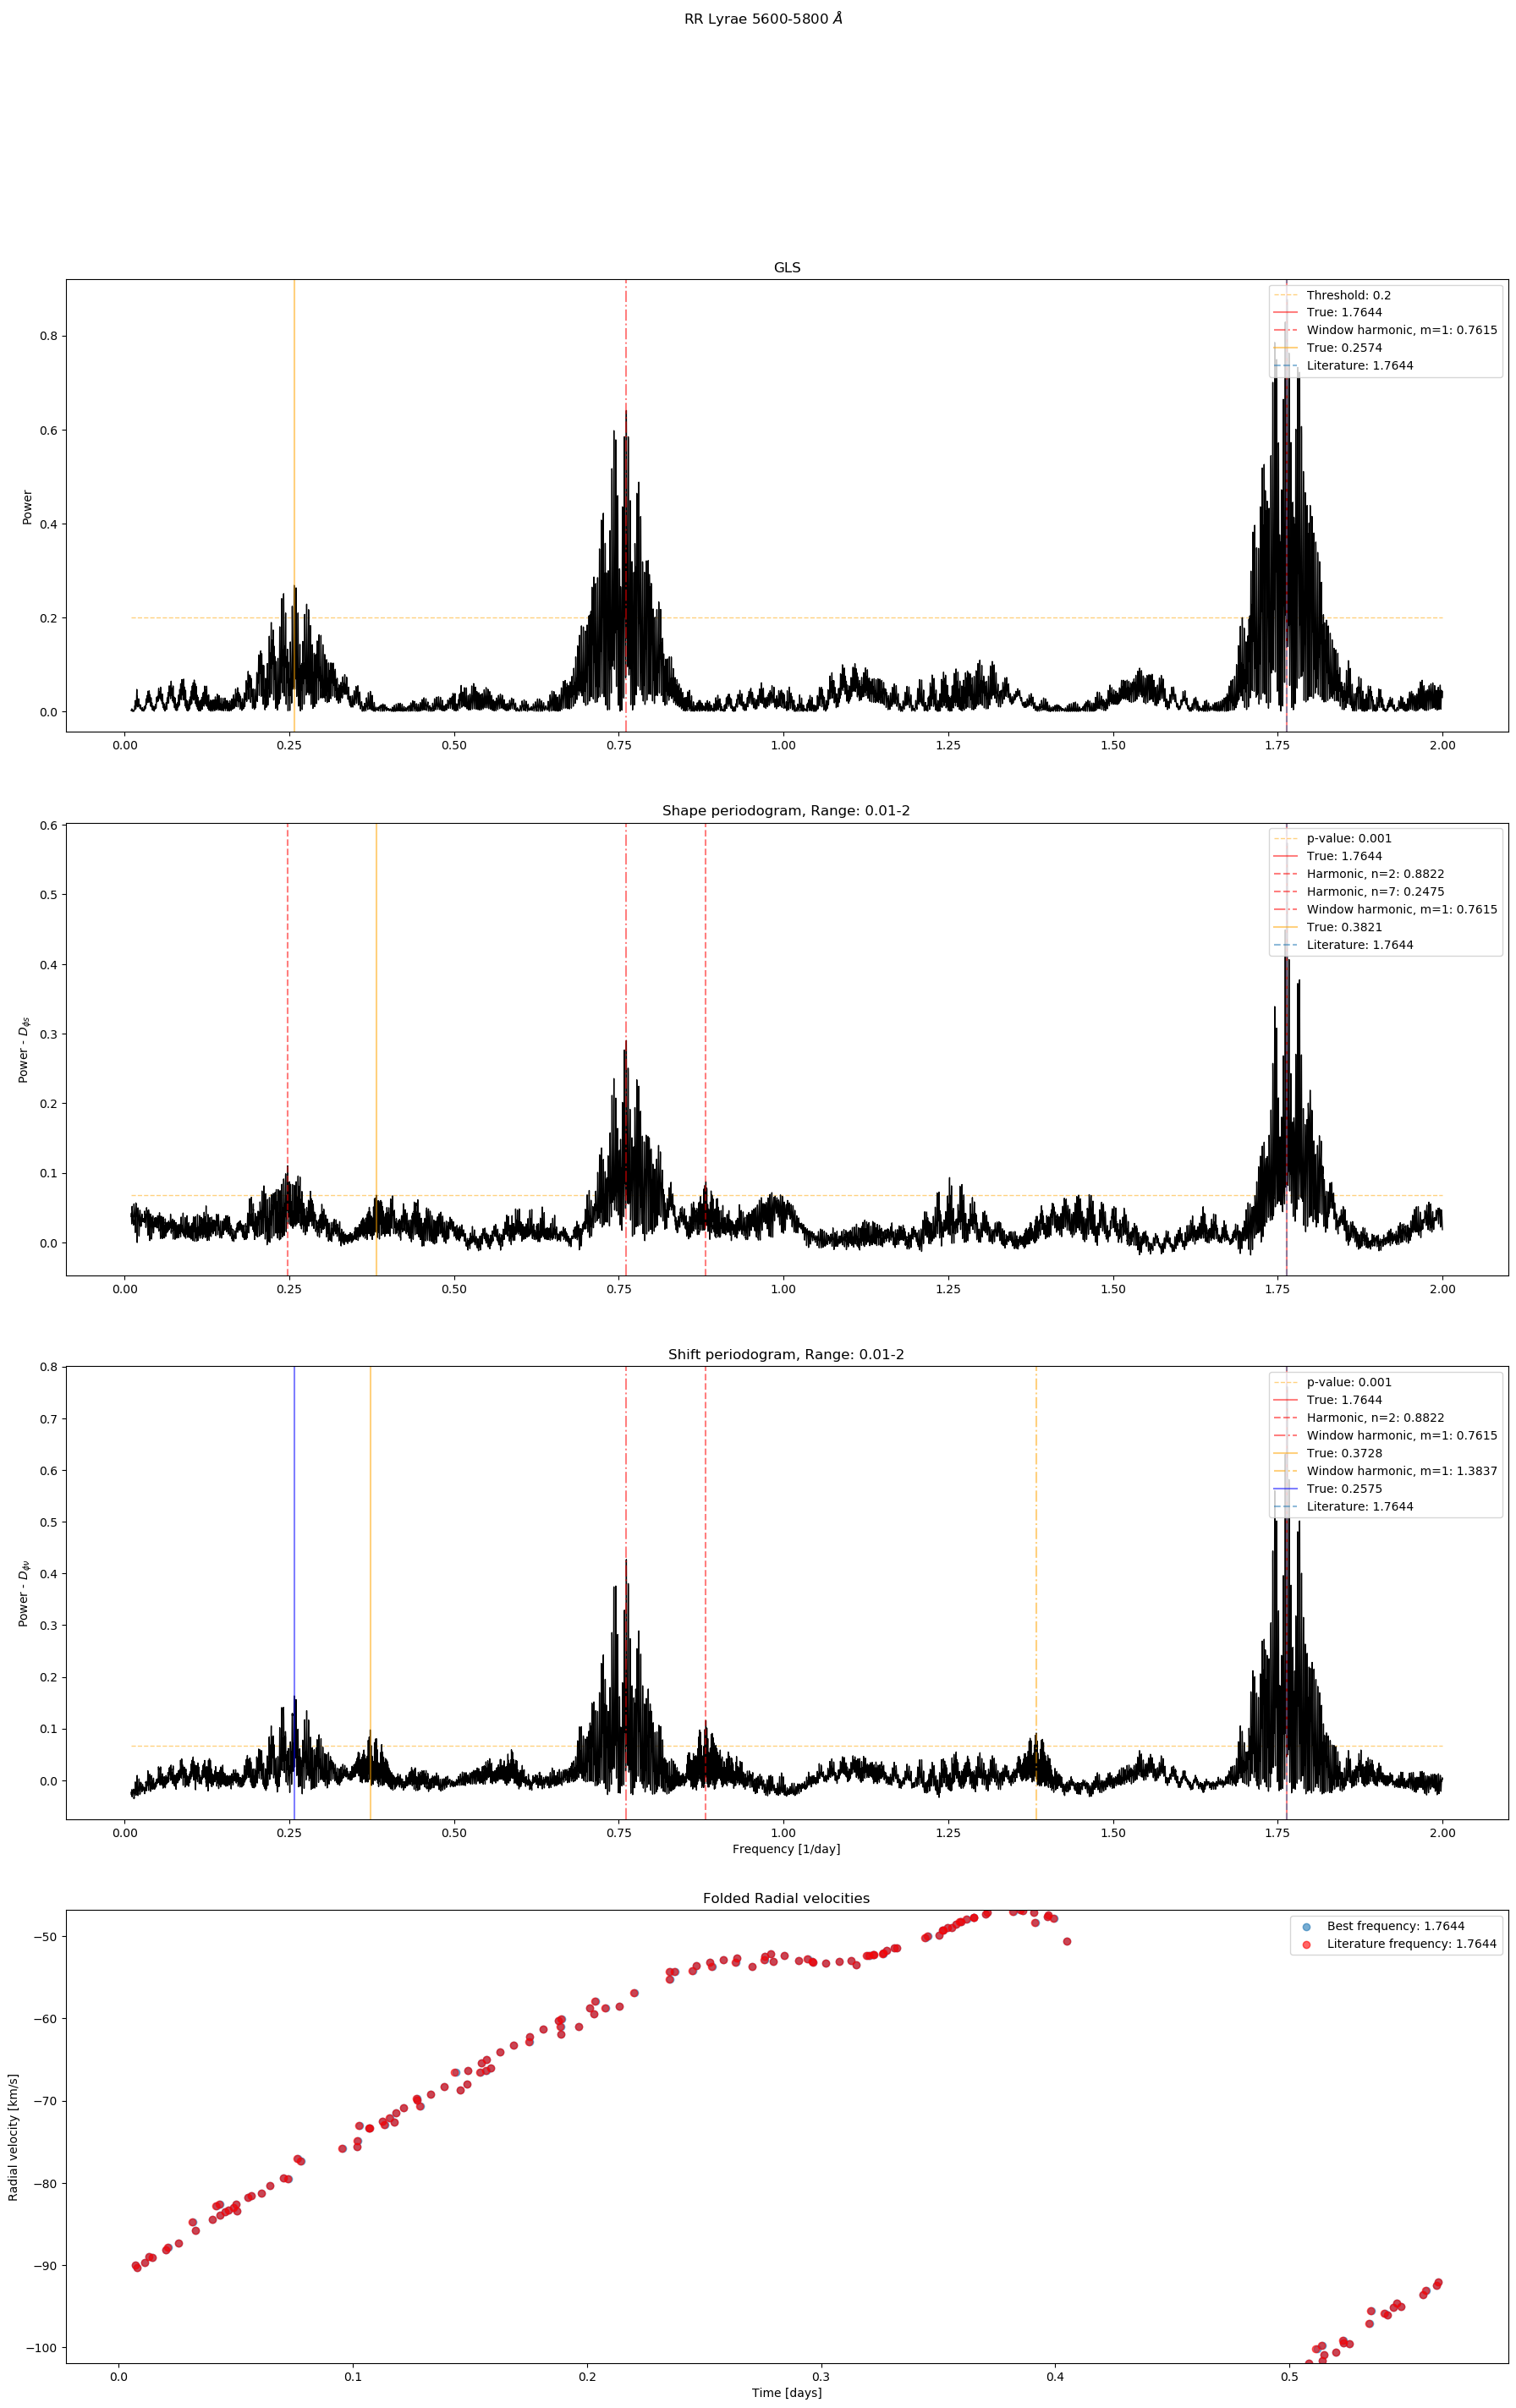

In [4]:
obs_data.periodicity_detector.plot_periodograms(annotate_pval=[1e-3], plot_rv=True,title=r"RR Lyrae 5600-5800 $\AA$", log_scale=False, plot_peaks=True)